In [1]:
!pip install gensim

In [2]:
import pandas as pd
import numpy as np
import json
import joblib as jb
import re
import ast
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import gensim.downloader as api
import gensim
from gensim.models import FastText

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [5]:
df_new = jb.load('/content/drive/MyDrive/BTP: Novel Recipe Generation (Constraint Optimization) 2023/Data/Preprocessed/data_v1.pickle')

In [6]:
df = pd.DataFrame(df_new)

**Formatting the Instructions of the Recipe by Performing operations like removing '\t' from the beginning of the instructions, inserting ';' at the end of each instruction, etc**

In [7]:
list_of_instrns = []
for row in range(0,len(df)):
    instr = df.iloc[row]['instructions']

    strg = ""
    length = len(instr) - 1
    count = 0
    for instruction in instr:
        processed_instr = []
        for j in range(0,len(instruction)):
            if(instruction[j]=='|' or instruction[j]=='\t'):
                continue
            elif(instruction[j]==' '):
                if(instruction[j-1]!='|'):
                   strg = strg + instruction[j]
            elif(instruction[j] == '.') and (j!=len(instruction)-1) and (instruction[j-1].isdigit()==False):
                strg = strg + ' '
                strg = strg + instruction[j]
            elif(instruction[j]>='a' and instruction[j]<='z') or (instruction[j]>='A' and instruction[j]<='Z') :
                 strg =  strg + instruction[j].lower()
            elif(instruction[j] == ','):
                  strg =  strg + ' '
                  strg =  strg + ','
            elif(instruction[j].isdigit()):
                if(instruction[j+1] == '.') or (instruction[j+2] == '.'):
                    continue
                else:
                    strg = strg + instruction[j]

        if(count!=length):
            strg = strg + ' '
            strg = strg + ';'
            strg = strg + ' '


        count = count + 1

    processed_instr.append(strg)
    list_of_instrns.append(processed_instr)

**Deleting the current "instructions" column from the DataFrame and inserting the modified Instructions by Creating the new "instructions" column**

In [8]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    return tokens

In [9]:
df.drop('instructions', inplace=True, axis=1)

In [10]:
df['instructions'] = list_of_instrns

In [11]:
df_top5 = df[df['region'].isin(['Italian', 'Mexican', 'South American', 'Canadian', 'Indian Subcontinent'])]

In [12]:
df_top5['preprocessed_title'] = df_top5['title'].apply(preprocess_text)
df_top5['preprocessed_ingredients'] = df_top5['ingredients'].apply(lambda x: [preprocess_text(ingredient) for ingredient in x])
df_top5['preprocessed_instructions'] = df_top5['instructions'].apply(lambda x: [preprocess_text(instruction) for instruction in x])

df_top5[['title', 'preprocessed_title', 'ingredients', 'preprocessed_ingredients', 'instructions', 'preprocessed_instructions']].head()

<ipython-input-12-24d2780f423b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top5['preprocessed_title'] = df_top5['title'].apply(preprocess_text)
<ipython-input-12-24d2780f423b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top5['preprocessed_ingredients'] = df_top5['ingredients'].apply(lambda x: [preprocess_text(ingredient) for ingredient in x])
<ipython-input-12-24d2780f423b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

,title,preprocessed_title,ingredients,preprocessed_ingredients,instructions,preprocessed_instructions
1087,Spicy Crab Curry - Bangla Style,"[spicy, crab, curry, bangla, style]","[mustard seed, water, mustard oil, clove, caye...","[[mustard, seed], [water], [mustard, oil], [cl...",[rub the crabs with 1 teaspoon of the turmeric...,"[[rub, crabs, teaspoon, turmeric, teaspoon, sa..."
1088,Machhere Jhol (Bengali Fish Curry),"[machhere, jhol, bengali, fish, curry]","[mustard seed, water, turmeric, fennel seed, c...","[[mustard, seed], [water], [turmeric], [fennel...","[bring the tomatoes , cumin , turmeric , salt ...","[[bring, tomatoes, cumin, turmeric, salt, wate..."
1089,Egg and Potato Curry,"[egg, potato, curry]","[garam masala, ginger paste, water, turmeric, ...","[[garam, masala], [ginger, paste], [water], [t...",[heat 1 tablespoon oil in a skillet over mediu...,"[[heat, tablespoon, oil, skillet, medium, heat..."
1090,Butter Lamb Gravy,"[butter, lamb, gravy]","[garam masala, water, turmeric, ginger, tomato...","[[garam, masala], [water], [turmeric], [ginger...",[season the lamb with garam masala and salt . ...,"[[season, lamb, garam, masala, salt, heat, tab..."
1091,Beef Samosas,"[beef, samosas]","[beef, phyllo dough, cumin seed, pea, coriande...","[[beef], [phyllo, dough], [cumin, seed], [pea]...",[bring a medium saucepan of lightly salted wat...,"[[bring, medium, saucepan, lightly, salted, wa..."


In [13]:
sentences = []
for index, row in df_top5.iterrows():
    for title_list in row['preprocessed_title']:
        t = []
        t.append(title_list)
        sentences.append(t)
    for ingredient_list in row['preprocessed_ingredients']:
        for ingredient in ingredient_list:
            sentences.append(ingredient.split())
    for instruction_list in row['preprocessed_instructions']:
        for instruction in instruction_list:
            sentences.append(instruction.split())
sentences

[['spicy'],
 ['crab'],
 ['curry'],
 ['bangla'],
 ['style'],
 ['mustard'],
 ['seed'],
 ['water'],
 ['mustard'],
 ['oil'],
 ['clove'],
 ['cayenne'],
 ['pepper'],
 ['black'],
 ['peppercorn'],
 ['garlic'],
 ['paste'],
 ['turmeric'],
 ['cinnamon'],
 ['white'],
 ['sugar'],
 ['cilantro'],
 ['garnish'],
 ['ginger'],
 ['paste'],
 ['thai'],
 ['green'],
 ['chile'],
 ['potato'],
 ['lengthwise'],
 ['tomato'],
 ['green'],
 ['cardamom'],
 ['pod'],
 ['salt'],
 ['dungeness'],
 ['crab'],
 ['red'],
 ['onion'],
 ['wedge'],
 ['lemon'],
 ['rub'],
 ['crabs'],
 ['teaspoon'],
 ['turmeric'],
 ['teaspoon'],
 ['salt'],
 ['let'],
 ['marinate'],
 ['hour'],
 ['combine'],
 ['mustard'],
 ['seed'],
 ['hot'],
 ['water'],
 ['small'],
 ['bowl'],
 ['let'],
 ['stand'],
 ['minutes'],
 ['use'],
 ['mortar'],
 ['pestle'],
 ['grind'],
 ['seeds'],
 ['coarse'],
 ['paste'],
 ['heat'],
 ['oil'],
 ['wok'],
 ['kadhai'],
 ['medium'],
 ['heat'],
 ['add'],
 ['crabs'],
 ['stir'],
 ['fry'],
 ['change'],
 ['color'],
 ['minutes'],
 ['remove'

In [14]:
df_I = df_top5[df_top5['region'].isin(['Italian'])]
df_M = df_top5[df_top5['region'].isin(['Mexican'])]
df_SA = df_top5[df_top5['region'].isin(['South American'])]
df_C = df_top5[df_top5['region'].isin(['Canadian'])]
df_IS = df_top5[df_top5['region'].isin(['Indian Subcontinent'])]

In [15]:
word2vec_model = Word2Vec(sentences, vector_size=768, window=5, min_count=1, workers=4)
word2vec_model.train(sentences, total_examples=len(sentences), epochs=50)

(181145024, 221370800)

In [16]:
word2vec_model.save("/content/drive/MyDrive/BTP: Novel Recipe Generation (Constraint Optimization) 2023/Models/word2vec_model.model")

In [17]:
word2vec_model.vector_size

768

In [18]:
def generate_embedding(words, model):
    embedding = np.zeros(model.vector_size)
    count = 0
    for word in words:
        if word in model.wv:
            embedding += model.wv[word]
            count += 1
    if count > 0:
        embedding /= count
    return embedding

In [19]:
recipe_embeddings = {}
for index, row in df_top5.iterrows():
    words = row['preprocessed_title'] + \
            [word for ingredient in row['preprocessed_ingredients'] for word in ingredient] + \
            [word for instruction in row['preprocessed_instructions'] for word in instruction]
    recipe_embedding = generate_embedding(words, word2vec_model)
    recipe_embeddings[row['ID']] = recipe_embedding

In [20]:
def generate_region_embeddings(df, recipe_embeddings):
    region_embeddings = {}
    for region in df['region'].unique():
        region_recipes = df[df['region'] == region]
        region_embedding = np.mean([recipe_embeddings[recipe_id] for recipe_id in region_recipes['ID']], axis=0)
        region_embeddings[region] = region_embedding
    return region_embeddings

In [21]:
region_embeddings = generate_region_embeddings(df_top5, recipe_embeddings)
region_embeddings

{'Indian Subcontinent': array([-3.39652096e-05, -7.88959299e-05, -5.42993118e-06,  1.45754893e-05,
         1.50696792e-05,  5.35066984e-05,  5.40540729e-06,  3.86442911e-05,
        -2.78643154e-05,  5.69259366e-06,  8.21029732e-05, -2.04136603e-05,
        -4.50135753e-07, -6.50295223e-05, -4.76920507e-05,  8.36018317e-05,
         2.35705755e-06,  8.69078962e-05, -7.77670376e-05,  6.28845267e-05,
        -4.89639466e-06,  3.36792622e-05,  6.27300413e-05, -9.55645920e-06,
        -6.92898726e-05,  1.99610489e-05, -4.88715287e-05, -1.25922246e-05,
        -1.10419555e-04, -7.06855492e-05,  3.91146093e-05, -9.20055771e-06,
         4.82282016e-05,  3.13037526e-05, -3.21737149e-05,  1.41757221e-05,
         1.53803260e-04, -8.18123158e-05, -4.12798668e-05, -5.83982230e-05,
        -2.51318741e-05,  3.07551861e-05,  3.23824061e-05, -7.34142319e-05,
         2.35193960e-05, -1.02473290e-04,  5.61104084e-05,  1.02878928e-06,
         4.39267125e-05,  4.49440235e-05, -9.28805234e-05, -2.242

In [22]:
embeddings_df = pd.DataFrame(region_embeddings).T
cosine_sim_matrix = cosine_similarity(embeddings_df)
cosine_sim_df = pd.DataFrame(cosine_sim_matrix, index=embeddings_df.index, columns=embeddings_df.index)

cosine_sim_df

,Indian Subcontinent,Mexican,South American,Italian,Canadian
Indian Subcontinent,1.000000,0.782021,0.713041,0.758805,0.802401
Mexican,0.782021,1.000000,0.786692,0.843921,0.822586
South American,0.713041,0.786692,1.000000,0.802925,0.777527
Italian,0.758805,0.843921,0.802925,1.000000,0.848240
Canadian,0.802401,0.822586,0.777527,0.848240,1.000000


In [23]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import random

# Number of iterations for averaging
num_iterations = 300

# Initialize a variable to sum the cosine similarity matrices
sum_similarity_matrix = None

for _ in range(num_iterations):
    selected_embeddings = []

    for region in ['Italian', 'Mexican', 'South American', 'Canadian', 'Indian Subcontinent']:
        # Filter embeddings for the current region
        region_embedding_ids = [id for id in df_top5[df_top5['region'] == region]['ID'] if id in recipe_embeddings]

        # Randomly select one embedding index
        if region_embedding_ids:
            selected_id = random.choice(region_embedding_ids)
            selected_embedding = recipe_embeddings[selected_id]
            selected_embeddings.append(selected_embedding)

    # Check if the correct number of embeddings are selected
    if len(selected_embeddings) == 5:  # 5 for five regions
        # Compute cosine similarity matrix for selected embeddings
        current_similarity_matrix = cosine_similarity(selected_embeddings)

        # Sum the similarity matrices
        if sum_similarity_matrix is None:
            sum_similarity_matrix = current_similarity_matrix
        else:
            sum_similarity_matrix += current_similarity_matrix

# Calculate the average cosine similarity matrix
average_similarity_matrix = sum_similarity_matrix / num_iterations

In [24]:
regions = ['Italian', 'Mexican', 'South American', 'Canadian', 'Indian Subcontinent']

In [25]:
print("Average Cosine Similarity Matrix:")
# Print header
print(" " * 20, end="")  # Adjust spacing based on your needs
for region in regions:
    print(f"{region:>20}", end="")  # Format for better alignment
print()

# Print each row with the region label
for i, region_row in enumerate(regions):
    print(f"{region_row:>20}", end="")  # Region label
    for sim in average_similarity_matrix[i]:
        print(f"{sim:>20.4f}", end="")  # Similarity values formatted to 4 decimal places
    print()

Average Cosine Similarity Matrix:
                                 Italian             Mexican      South American            Canadian Indian Subcontinent
             Italian              1.0000              0.1537              0.1631              0.1236              0.1524
             Mexican              0.1537              1.0000              0.1552              0.1085              0.1564
      South American              0.1631              0.1552              1.0000              0.1346              0.1608
            Canadian              0.1236              0.1085              0.1346              1.0000              0.1256
 Indian Subcontinent              0.1524              0.1564              0.1608              0.1256              1.0000


### Clustering

10 clusters

In [ ]:
from sklearn.cluster import KMeans

# Assuming recipe_embeddings is a dictionary with recipe IDs as keys and embeddings as values
embeddings = list(recipe_embeddings.values())  # Extracting embeddings

# Decide on the number of clusters
n_clusters = 10  # for example

# Perform clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(embeddings)

# Getting cluster labels
cluster_labels = kmeans.labels_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
# Assuming the index of df_balanced corresponds to the keys in recipe_embeddings
df_top5['cluster'] = cluster_labels

<ipython-input-24-85e802956cf3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top5['cluster'] = cluster_labels


In [ ]:
# Group by cluster and then calculate the percentage of each region
cluster_region_distribution = df_top5.groupby('cluster')['region'].value_counts(normalize=True) * 100

In [ ]:
cluster_region_distribution

cluster  region             
0        Canadian               36.997498
         Italian                32.810676
         Mexican                15.462886
         Indian Subcontinent    10.158465
         South American          4.570475
1        Mexican                77.838001
         South American          9.756098
         Italian                 6.383619
         Canadian                5.420054
         Indian Subcontinent     0.602228
2        Mexican                41.498625
         Italian                31.141155
         Indian Subcontinent    15.123740
         Canadian                9.280477
         South American          2.956004
3        South American         74.763472
         Mexican                10.612916
         Italian                10.180995
         Canadian                3.517071
         Indian Subcontinent     0.925545
4        Mexican                53.793627
         Canadian               18.133536
         Indian Subcontinent    10.849772
     

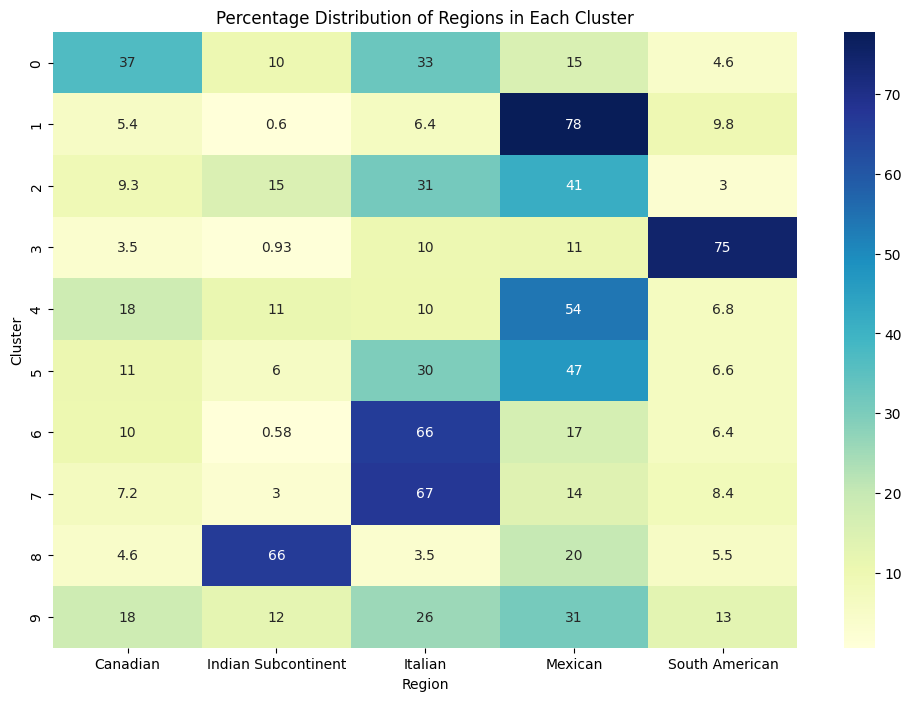

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert the Series to a DataFrame for easier plotting
cluster_region_distribution_df = cluster_region_distribution.reset_index(name='percentage')

# Pivot the DataFrame to have regions as columns and clusters as rows
pivot_df = cluster_region_distribution_df.pivot(index='cluster', columns='region', values='percentage').fillna(0)

# Plot
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_df, annot=True, cmap="YlGnBu")
plt.title('Percentage Distribution of Regions in Each Cluster')
plt.xlabel('Region')
plt.ylabel('Cluster')
plt.show()

5 clusters

In [ ]:
from sklearn.cluster import KMeans

# Assuming recipe_embeddings is a dictionary with recipe IDs as keys and embeddings as values
embeddings = list(recipe_embeddings.values())  # Extracting embeddings

# Decide on the number of clusters
n_clusters = 5  # for example

# Perform clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(embeddings)

# Getting cluster labels
cluster_labels = kmeans.labels_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
# Assuming the index of df_balanced corresponds to the keys in recipe_embeddings
df_top5['cluster'] = cluster_labels

<ipython-input-29-85e802956cf3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top5['cluster'] = cluster_labels


In [ ]:
# Group by cluster and then calculate the percentage of each region
cluster_region_distribution = df_top5.groupby('cluster')['region'].value_counts(normalize=True) * 100

In [ ]:
cluster_region_distribution

cluster  region             
0        Mexican                41.530612
         Italian                30.204082
         Indian Subcontinent    16.653061
         Canadian                8.755102
         South American          2.857143
1        Mexican                33.126775
         Italian                26.448059
         South American         22.712798
         Canadian               11.283243
         Indian Subcontinent     6.429125
2        Canadian               30.740421
         Italian                27.158360
         Mexican                21.549986
         Indian Subcontinent    14.289830
         South American          6.261404
3        Italian                36.573865
         Indian Subcontinent    21.665267
         Mexican                17.492410
         South American         17.447193
         Canadian                6.821265
4        Mexican                40.409579
         Italian                39.514324
         South American         11.627126
     

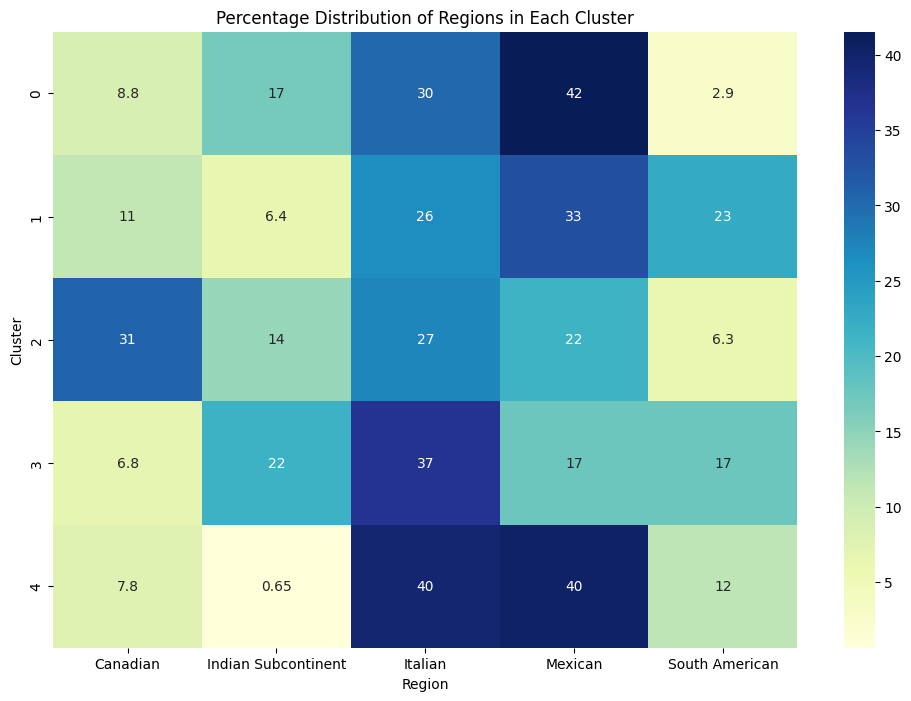

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert the Series to a DataFrame for easier plotting
cluster_region_distribution_df = cluster_region_distribution.reset_index(name='percentage')

# Pivot the DataFrame to have regions as columns and clusters as rows
pivot_df = cluster_region_distribution_df.pivot(index='cluster', columns='region', values='percentage').fillna(0)

# Plot
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_df, annot=True, cmap="YlGnBu")
plt.title('Percentage Distribution of Regions in Each Cluster')
plt.xlabel('Region')
plt.ylabel('Cluster')
plt.show()